# Week 6 
This is a practise notebook created during Week-6 of ML Zoomcamp.

***

# Download dataset

In [20]:
PATH_DATASET="https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv"

In [21]:
!wget $PATH_DATASET -O ../data/06_data_creditscoring.csv

--2022-10-15 16:56:15--  https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv [following]
--2022-10-15 16:56:16--  https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘../data/06_data_creditscoring.csv’

../data/06_data_cre 100%[===================>] 178.21K  --.-KB/s    in 0.03s   

2022-10-15 16:56:16 (5.33 MB/s) - ‘../data/06_data_creditscoring.csv’ saved [1824

In [22]:
!head ../data/06_data_creditscoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


***

# Import modules

In [43]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [44]:
import sys 
sys.path.append('../src/')

import utilities as utils

In [224]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text, export_graphviz

from IPython.display import display, Image
import graphviz

***

# Read using Pandas

In [31]:
df = pd.read_csv('../data/06_data_creditscoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


***

# Data Prep and Cleaning

## Standardize column names

In [32]:
df.columns = df.columns.str.lower()
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

## Map column data 

In [33]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [34]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [35]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [36]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


## Replace 99999999 with NaNs

In [37]:
# Replace 99999999.0 as NaNs
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [38]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


## Drop Status='Unk' rows

In [40]:
# Drop 'Unk' status rows
df = df[df['status'] != 'unk'].reset_index(drop=True)
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4454.0,4454.0,4454.0,4454.0,4420.0,4407.0,4436.0,4454.0,4454.0
mean,8.0,46.0,37.0,56.0,131.0,5404.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11574.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


***

## Prepare dataset

In [132]:
# Test-Train split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [133]:
# Convert status - categorical into numerical
df_train_full.status = (df_train_full.status == 'default').astype('int').values
df_train.status = (df_train.status == 'default').astype('int').values
df_val.status   = (df_val.status == 'default').astype('int').values
df_test.status  = (df_test.status == 'default').astype('int').values

In [134]:
# Prepare dataset for modeling- features and target
df_train_full, y_train_full = utils.dataset_into_features_and_target(df_train_full, 'status')
df_train, y_train = utils.dataset_into_features_and_target(df_train, 'status')
df_val, y_val     = utils.dataset_into_features_and_target(df_val, 'status')
df_test, y_test   = utils.dataset_into_features_and_target(df_test, 'status')

In [135]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
951,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
688,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2233,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3304,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
2271,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
1784,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
808,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
1857,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


***

# Decision trees

In [156]:
train_dicts = df_train.fillna(0.0).to_dict(orient='records')
val_dicts   = df_val.fillna(0.0).to_dict(orient='records')

## Dict Vectorizer

In [157]:
dv = DictVectorizer(sparse=False)

In [158]:
# Apply dv on train dataset
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Train Decision Tree

In [171]:
# Train DT
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

## On Validation Dataset

In [172]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print(f'Test={auc}')

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print(f'Val={auc}')

Test=0.7761016984958594
Val=0.7389079944782155


## View Dt trained

In [176]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



In [189]:
export_graphviz(dt, out_file='dt.txt', feature_names=dv.get_feature_names())

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


***

# Decision tree learning algorithm

In [195]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 50]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = utils.roc_auc_score(y_val, y_pred)
    
    print(f"Depth={depth:.1f} AUC={auc:.4f}")


Depth=1.0 AUC=0.6059
Depth=2.0 AUC=0.6685
Depth=3.0 AUC=0.7389
Depth=4.0 AUC=0.7613
Depth=5.0 AUC=0.7669
Depth=6.0 AUC=0.7462
Depth=10.0 AUC=0.6787
Depth=15.0 AUC=0.6668
Depth=20.0 AUC=0.6479
Depth=50.0 AUC=0.6578


In [198]:

list_auc = []
scores = [1, 5, 10, 15, 20, 100, 200, 500]
depths = [4, 5, 6]

for score in scores:
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=score)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = utils.roc_auc_score(y_val, y_pred)
        
        list_auc.append((depth, score, auc))

        print(f"Depth={depth:.1f} Score={score:.1f} AUC={auc:.4f}")


Depth=4.0 Score=1.0 AUC=0.7613
Depth=5.0 Score=1.0 AUC=0.7665
Depth=6.0 Score=1.0 AUC=0.7586
Depth=4.0 Score=5.0 AUC=0.7613
Depth=5.0 Score=5.0 AUC=0.7678
Depth=6.0 Score=5.0 AUC=0.7612
Depth=4.0 Score=10.0 AUC=0.7613
Depth=5.0 Score=10.0 AUC=0.7618
Depth=6.0 Score=10.0 AUC=0.7775
Depth=4.0 Score=15.0 AUC=0.7637
Depth=5.0 Score=15.0 AUC=0.7724
Depth=6.0 Score=15.0 AUC=0.7852
Depth=4.0 Score=20.0 AUC=0.7609
Depth=5.0 Score=20.0 AUC=0.7740
Depth=6.0 Score=20.0 AUC=0.7740
Depth=4.0 Score=100.0 AUC=0.7559
Depth=5.0 Score=100.0 AUC=0.7634
Depth=6.0 Score=100.0 AUC=0.7764
Depth=4.0 Score=200.0 AUC=0.7473
Depth=5.0 Score=200.0 AUC=0.7591
Depth=6.0 Score=200.0 AUC=0.7683
Depth=4.0 Score=500.0 AUC=0.6798
Depth=5.0 Score=500.0 AUC=0.6798
Depth=6.0 Score=500.0 AUC=0.6798


In [199]:
columns = ['max_depth','min_samples_leaf','auc']

df_aucs = pd.DataFrame(list_auc, columns=columns)
df_aucs

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,5,1,0.766496
2,6,1,0.758625
3,4,5,0.761283
4,5,5,0.767755
5,6,5,0.761225
6,4,10,0.761283
7,5,10,0.761809
8,6,10,0.777521
9,4,15,0.763726


In [200]:
# Pivot 
df_aucs_pivot = df_aucs.pivot(index='min_samples_leaf',
                              columns=['max_depth'],
                              values=['auc'])

df_aucs_pivot

auc                    
max_depth                4         5         6
min_samples_leaf                              
1                 0.761283  0.766496  0.758625
5                 0.761283  0.767755  0.761225
10                0.761283  0.761809  0.777521
15                0.763726  0.772405  0.785250
20                0.760910  0.774028  0.773982
100               0.755937  0.763384  0.776434
200               0.747260  0.759073  0.768267
500               0.679842  0.679842  0.679842

## Heatmap of paramters-auc of DT

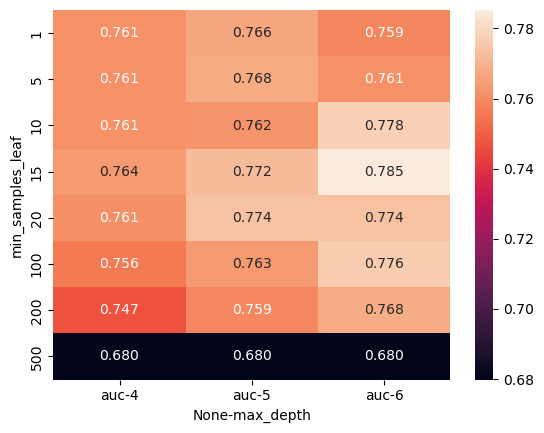

In [232]:
# Heatmap 
sns_plot = sns.heatmap(df_aucs_pivot, annot=True, fmt='.3f')
plt.savefig('../images/6_dt_heatmap.png')

In [203]:
# Training DT with selected parametsr
dt = DecisionTreeClassifier(max_depth=6,
                            min_samples_leaf=15)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## Export DT as text 

In [204]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- income <= 117.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  117.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Export DT as graphviz

In [211]:
# Visualize using GraphViz for dT
export_graphviz(dt, out_file="6_dt.dot",
                    feature_names=dv.get_feature_names(),
                    class_names='status',
                    filled=True, rounded=True, 
                    special_characters=True)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


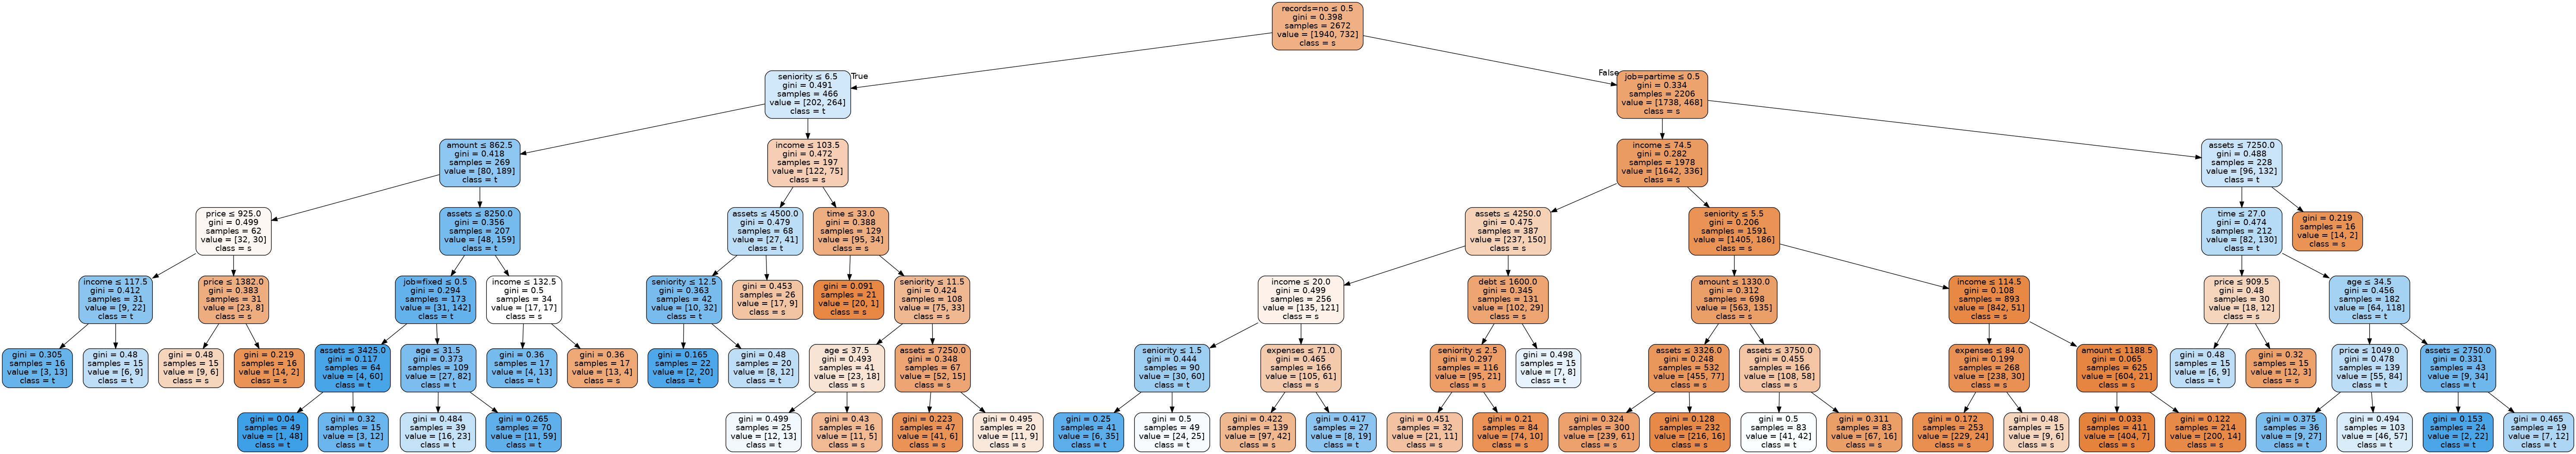

In [229]:
Image("../images/6_dt.png", width=400, height=800)

***